<a href="https://colab.research.google.com/github/luquelab/dynamics/blob/Colab/dynamic_regimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Regimes

## Description
This notebook identifies the different dynamic regimes of a given model when specifying an observational time. The notebook is based on ongoing research on transient dynamics by the [Luque lab](https://www.luquelab.com/) and [Rohwer lab](https://coralandphage.org/) with research scientists [Sergio Cobo-Lopez](https://scholar.google.com/citations?user=m6m1HV4AAAAJ&hl=en) and Matthew Witt as the main contributors to the project. Follow the Quick-Start Guide section to get started.

## Quick-Start Guide
Here are the recommendations to obtain results when running the notebook:
1. If it is your first time using the notebook, we recommend that you test that the notebook runs well in your browser using the default values. This should generate the outputs TBD. If you have any issues, check the section TBD.
2. After testing that the notebook works on your browser, set the specific model you aim to investigate following the instructions in the [User Input](#scrollTo=User_Input). You can either edit the model manually or import it as a JSON file, e.g., froma a previously generated model.
4. Run the block TBD.
5. Check downloads and report (TBD)

# User Input
This section allow users to define a new model and its conditions or upload a previously defined model.

In [1]:
# User input

## Choose if the model will be uploaded
upload = True ## Values: `True` or `False`. If True, it expects to upload model as JSON file.

## If upload is False, edit the lines below to define the new model
### Set variables info
variables = ['Time','Bacteria','Phage']
variables_symbols = ['t','B','P']
variables_units = ['h','cells/ml','phages/ml']
variables_independence = [True,False,False]
variables_with_mechanisms = variables[1:]
mechanisms = [['growth','predation'],
                ['burst','decay']]
expressions = [['+r*B','-aB*B*P'],
                 ['c*aP*B*P','-m*P']]
variables_values = [0,100,100]

### Set parameters info
parameters = ['growth_constant','infection_constant_to_B',
                'burst_size','infection_constant_from_P','decay_constant']
parameters_symbols = ['r','aB',
                        'c','aP','m']
parameters_units = ['1/h','ml/(h*phage)',
                      '','ml/(h*cell)','1/h']
parameters_values = [1,2,
                       3,1,2]

### Set observer info
observational_time = 10
observational_time_units = variables_units[0]
system_size = 1
system_size_units = 'ml'


## If upload is True the coad below will request to upload the model (no need to modify)
if upload:
  # Upload model from JSON file
  from google.colab import files
  import json

  uploaded = files.upload()
  model_bytes = next(iter(uploaded.values()))
  model = json.loads(model_bytes.decode())
  print('Model uploaded')


Saving model_Lotka-Volterra_phage-bacteria.json to model_Lotka-Volterra_phage-bacteria.json
Model uploaded


# Set System and Model
This section installs any necessary packages, imports the libraries needed for the code, and defines the necessary objects to execute the notebook.

## Installations
The code below installs the necessary packages in the Colab server.

In [2]:
# Installations
## No installations needed yet.

## Imports
The code below installs the necessary libraries to run the notebook.

In [3]:
# Imports
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import json
from google.colab import files

## Definitions
The code below defines the necessary objects that have been developed specifically for this project and are necessary to generate the model and the results.

In [4]:
# Definitions

##############
## Class to generate objects containing the necessary information about a model
##############
class Model:
  def __init__(self, observer:dict={}, variables:dict={}, parameters:dict={}):
    self.observer = observer
    self.variables = variables
    self.parameters = parameters

  def __str__(self):
    return json.dumps(self.__dict__)

  def __repr__(self):
    return self.__str__()

  # Add variables
  def add_variables(self, variables:list):
    for variable in variables:
      self.variables[variable] = {}

  # Add symbols to variables
  def add_symbols_to_variables(self,variables:list, symbols:list):
    for index, variable in enumerate(variables):
      self.variables[variable]['symbol'] = symbols[index]

  # Add units to variables
  def add_units_to_variables(self, variables:list, units:list):
    for index, variable in enumerate(variables):
      self.variables[variable]['unit'] = units[index]

  # Add status to variables
  def add_status_to_variables(self,variables:list, independence:list):
    for index,variable in enumerate(variables):
      self.variables[variable]['independent'] = independence[index]

  # Add mechanisms contributing to the rate of change of variables
  def add_mechanisms(self, variables:list, mechanisms:list, expressions:list):
    for index,variable in enumerate(variables):
      self.variables[variable]['mechanisms'] = {}

      variable_mechanisms = mechanisms[index]
      variable_mechanisms_expressions = expressions[index]
      for index,mechanism in enumerate(variable_mechanisms):
         self.variables[variable]['mechanisms'][mechanism] = variable_mechanisms_expressions[index]

  # Add initial values to variables
  def add_initial_values_to_variables(self,variables:list,values:list):
    for index,variable in enumerate(variables):
      self.variables[variable]['initial_value'] = values[index]

  # Add parameters
  def add_parameters(self, parameters:list):
    for parameter in parameters:
      self.parameters[parameter] = {}

  # Add symbols to parameters
  def add_symbols_to_parameters(self,parameters:list, symbols:list):
    for index, parameter in enumerate(parameters):
      self.parameters[parameter]['symbol'] = symbols[index]

  # Add units to parameters
  def add_units_to_parameters(self, parameters:list, units:list):
    for index, parameter in enumerate(parameters):
      self.parameters[parameter]['unit'] = units[index]

  # Add initial values to parameters
  def add_initial_values_to_parameters(self,parameters:list,values:list):
    for index,parameter in enumerate(parameters):
      self.parameters[parameter]['value'] = values[index]

  # Add observer time
  def add_observer_time(self, observational_time:float, units:str):
    self.observer['observational_time'] = {}
    self.observer['observational_time']['unit'] = units
    self.observer['observational_time']['value'] = observational_time

  # Add system size
  def add_system_size(self, system_size:float, units:str):
    self.observer['system_size'] = {}
    self.observer['system_size']['unit'] = units
    self.observer['system_size']['value'] = system_size


################
## Function that generates the system of differential equations given a model
################
def generate_model_system(model:dict):
  """
  Function generating a function for the differential equations of a given model.

  Args:
      model (dict): Dictionary describing the model

  Returns:
      str: Python code defining the function for the model
  """
  system = ''

  # Iterate over the dependent variables in the model
  for variable in model['variables']:

    # Load dictionary associated with the variable
    variable_dict = model['variables'][variable]

    # Chaeck is independency and accept if False
    independent = variable_dict['independent']
    if not independent:

      # Build equation for the variable
      symbol = variable_dict['symbol']
      equation = symbol+'_dot = '
      for mechanism in variable_dict['mechanisms']:
        expression = variable_dict['mechanisms'][mechanism]
        equation += expression+' '

      # Update system
      system += equation+'\n'
  return system


########
## Function to obtain the symbols of the variables
########
def get_variables_symbols(model:dict):
  """
  Function that obtains the symbols of the variables of a model.
  Uses a model as input and returns a tuple with the symbols of the variables.

  Args:
      model (dict): Dictionary describing the model

  Returns:
      Tuple: Two objects
        Str: Symbol for the independent variable
        List: Symbols for the dependent variables
  """

  # Set list for dependent variables
  dependent_variables_symbol = []

  # Obtain variable symbols
  for variable in model['variables']:

    # Obtain dictionary for each variable
    variable_dict = model['variables'][variable]

    # Distinguish between independent and dependent variables
    independence = variable_dict['independent']
    if independence:
      # Obtain and store symbol
      variable_symbol = variable_dict['symbol']
      independent_variable_symbol = variable_symbol

    else:
      # Obtain and store symbol
      variable_symbol = variable_dict['symbol']

      # Append symbol and value to list
      dependent_variables_symbol.append(variable_symbol)

  # Return variables
  output = (independent_variable_symbol,dependent_variables_symbol)
  return output

################
## Function to obtain the parameter values of the model
################
def get_model_parameters(model:dict):
  """
  Function that obtains the peramaters of a given model.
  It expects a model as a dictionary and returns the symbols and values each as a tuple.

  Args:
      model (dict): Dictionary describing the model

  Returns:
      List: Two tuples
        tuple: symbols associated with the parameters.
        tuple: values associated with the parameters.
  """

  # Obtain dictionary for the parameters
  parameters = model['parameters']

  # Set the lists that later will become tuples
  param_symbols_list = []
  param_values_list = []
  for parameter in parameters:
    # Obtain the dictionary for the specific parameter
    parameter_dict = parameters[parameter]

    # Obtain and store symbol
    symbol = parameter_dict['symbol']
    param_symbols_list.append(symbol)

    # Obtain and store value
    value = parameter_dict['value']
    param_values_list.append(value)

  # Print what was obtained
  print(f'Parameter symbols: {param_symbols_list}')
  print(f'Parameter values: {param_values_list}')

  # Return the results as tuples
  param_symbols = tuple(param_symbols_list)
  param_values = tuple(param_values_list)
  output = [param_symbols,param_values]
  return output



############
## Function that returns the initial conditions for the variables in the model
############
def get_initial_conditions(model:dict):
  """
  Function that returns the initial conditions of the variables.

  Args:
      model (dict): Dictionary describing the model

  Returns:
      Tuple: Two lists
        List: Symbols for the initial conditions
        List: Values for the initial conditions
  """

  # Initiate lists
  initial_conditions_list = []
  initial_variables_list = []

  # Obtain dictionary for variables and loop through them
  variables = model['variables']
  for variable in variables:
    # Obtain dictionary for each variable
    variable_dict = variables[variable]

    # Obtain and store symbol
    symbol = variable_dict['symbol']
    initial_variables_list.append(symbol+'0')

    # Obtain and store value
    value = variable_dict['initial_value']
    initial_conditions_list.append(value)

  # Print output
  print(f'Initial symbol: {initial_variables_list}')
  print(f'Initial values: {initial_conditions_list}')

  # Prepare output as tuple for return
  output = (initial_variables_list,initial_conditions_list)
  return output


#######
## Function to generate the model equation as a python function .py
#######
def generate_model_fun(param_symbols:tuple,depend_variables_symbol:list,model_eqs:str):
  """
  Function that generates the python function for the model in a .py file.
  It takes the parameter symbols, dependent variable sybmols, and system of equations.
  It returns a string with the model and generates the python function as a file.py
  !!!! If the model was defined as a class with methods, this function would be more straightforward.

  Args:
    param_symbols: tuple of parameter symbols
    depend_variables_symbol: list of dependent variable symbols
    model_eqs: string of the system of equations

  Returns:
    output: string of the python code
  """

  ## Initialize output string
  output = ''

  ## Open file
  name = 'model_fun'
  file = open(f'{name}.py','w')

  ## Write definition line
  params = ','.join(param_symbols)
  definition = f'def {name}(t,y,{params}):' + '\n'
  file.write(definition)
  output += definition

  ## Write initial values
  index = 0
  for symbol in depend_variables_symbol:
    line = '\t' + f'{symbol} = y[{index}]'  + '\n'
    output += line
    file.write(line)
    index += 1

  ## Write system of equations

  line = '\n'
  output += line
  file.write(line)
  eqs_list = model_eqs.split('\n')
  for equation in eqs_list:
    eq_line = '\t' + equation  + '\n'
    output += eq_line
    file.write(eq_line)

  ## Write formatted output for y_dot
  y_dot = 'y_dot = ['
  for equation in eqs_list:
    # Obtain and recast the symbols for the derivatives to the generic y_dot
    variable_dot = equation.split('=')[0]
    y_dot += variable_dot +','

  y_dot = y_dot.rstrip(',')
  y_dot += ']'
  y_dot_line = '\t'+ y_dot  + '\n'

  output += y_dot_line
  file.write(y_dot_line)

  ## Write return output
  return_line = '\t'+ 'return y_dot'
  output += return_line
  file.write(return_line)

  ## Close file
  file.close()

  ## Return output
  return output


#######
## Function that generates a python function (as .py file) given a mechanism
#######
def generate_func_mechanism(param_symbols:tuple,depend_variables_symbol:list,mechanism:str,name:str):
  """
  Function that generates python functions as .py files for the mechanisms of the model.
  It takes the parameter symbols, dependent variable sybmols, and system of equations.
  It returns python functions as a file.py
  !!!! If the model was defined as a class with methods, this function would be more straightforward.

  Args:
    param_symbols: tuple of parameter symbols
    depend_variables_symbol: list of dependent variable symbols
    mechanism: string of the system of equations
    name: name of the function to be generated

  Returns:
    output: string of the python code
    file: name.py file with the python code
  """

  ## Initialize output string
  output = ''

  ## Open file
  file = open(f'{name}.py','w')

  ## Write definition line
  params = ','.join(param_symbols)
  definition = f'def {name}(t,y,{params}):' + '\n'
  file.write(definition)
  output += definition

  ## Write initial values
  index = 0
  for symbol in depend_variables_symbol:
    line = '\t' + f'{symbol} = y[{index}]'  + '\n'
    output += line
    file.write(line)
    index += 1

  ## Write return output
  return_line = '\n\t'+ f'return {mechanism}'
  output += return_line
  file.write(return_line)

  ## Close file
  file.close()

  ## Return output
  return output

# Model and Conditions
This section provides the code to facilitate users to set their specific models and observational conditions of interest.

## Set Model
The code below allows users to define their specific model, which is expected to be based on a system of differential equations. The system is expected to have a single independent variable, assumed to be time.

In [5]:
# Set model
## The code below will run to generate the model if the user chose upload=False.
if not upload:
  # Set model instance
  model_object = Model()

  ## Set observer info
  observational_time = 10
  observational_time_units = variables_units[0]
  system_size = 1
  system_size_units = 'ml'

  ## Load variables info to the model
  model_object.add_variables(variables)
  model_object.add_symbols_to_variables(variables,variables_symbols)
  model_object.add_units_to_variables(variables,variables_units)
  model_object.add_status_to_variables(variables,variables_independence)
  model_object.add_mechanisms(variables_with_mechanisms,mechanisms,expressions)
  model_object.add_initial_values_to_variables(variables,variables_values)

  ## Load parameters info to the model
  model_object.add_parameters(parameters)
  model_object.add_symbols_to_parameters(parameters,parameters_symbols)
  model_object.add_units_to_parameters(parameters,parameters_units)
  model_object.add_initial_values_to_parameters(parameters,parameters_values)

  ## Load observer info to the model
  model_object.add_observer_time(observational_time,observational_time_units)
  model_object.add_system_size(system_size,system_size_units)

  model = model_object.__dict__

  ## Store model
  with open(f'model.json', 'w') as file:
    json.dump(model, file, indent=4)


In [6]:
# Display model
model

{'observer': {'observational_time': {'unit': 'h', 'value': 10},
  'system_size': {'unit': 'ml', 'value': 1}},
 'variables': {'Time': {'symbol': 't',
   'unit': 'h',
   'initial_value': 0,
   'independent': True},
  'Bacteria': {'symbol': 'B',
   'unit': 'cells/ml',
   'initial_value': 1,
   'independent': False,
   'mechanisms': {'growth': '+r*B', 'predation': '-aB*B*P'}},
  'Phage': {'symbol': 'P',
   'unit': 'phage/ml',
   'initial_value': 1,
   'independent': False,
   'mechanisms': {'burst': '+c*aP*B*P', 'decay': '-m*P'}}},
 'parameters': {'growth_constant': {'symbol': 'r', 'unit': '1/h', 'value': 1},
  'infection_constant_to_B': {'symbol': 'aB',
   'unit': 'ml/(h*phage)',
   'value': 1},
  'burst_size': {'symbol': 'c', 'unit': 'phage', 'value': 3},
  'infection_constant_from_P': {'symbol': 'aP',
   'unit': 'ml/(h*cell)',
   'value': 1},
  'decay_constant': {'symbol': 'm', 'unit': '1/h', 'value': 0.1}}}

### Generate equations

In [7]:
# Generate and display equations
model_eqs = generate_model_system(model=model)
print(model_eqs)

B_dot = +r*B -aB*B*P 
P_dot = +c*aP*B*P -m*P 



### Generate python functions

In [8]:
# Load the model as a function that can be integrated

## Get symbols for dependent variables and
indep_variable_symbol, depend_variables_symbol = get_variables_symbols(model)
param_symbols, param_values = get_model_parameters(model)
model_fun_str = generate_model_fun(param_symbols,depend_variables_symbol,model_eqs)
print(model_fun_str)
exec(model_fun_str)

Parameter symbols: ['r', 'aB', 'c', 'aP', 'm']
Parameter values: [1, 1, 3, 1, 0.1]
def model_fun(t,y,r,aB,c,aP,m):
	B = y[0]
	P = y[1]

	B_dot = +r*B -aB*B*P 
	P_dot = +c*aP*B*P -m*P 
	
	y_dot = [B_dot ,P_dot ]
	return y_dot


## Set Conditions
This section allow users to define their observational time, the initial conditions for the dynamic variables, and the values of the parameters in the model.

In [9]:
# Conditions

## Parameters
[param_symbols,param_values] = get_model_parameters(model=model)

## Initial values
inital_symbols, initial_values = get_initial_conditions(model=model)
y0 = initial_values[1:]

## Time conditions
## Obtain time conditions from model
t0 = model['variables']['Time']['initial_value']
tend = model['observer']['observational_time']['value']
tspan = [t0,tend]
max_step = 0.01
print(f't0 = {t0}')
print(f'tend = {tend}')
print(f'max_step = {max_step}')

Parameter symbols: ['r', 'aB', 'c', 'aP', 'm']
Parameter values: [1, 1, 3, 1, 0.1]
Initial symbol: ['t0', 'B0', 'P0']
Initial values: [0, 1, 1]
t0 = 0
tend = 10
max_step = 0.01


# Simulate model

In [10]:
args = param_values
#solution = solve_ivp(test_model, tspan, y0, args=args, dense_output=True,max_step=max_step)
fun = model_fun
solution = solve_ivp(fun, tspan, y0, args=args, dense_output=True,max_step=max_step)

# Obtain mechanisms' weigths

## Generate functions for each mechanism

In [49]:
# Identify mechanisms for each dependent variable
print('Generating a function for each mechanism (STARTED)')

## Loop over variables
for variable in model['variables'].keys():

  ### Select only if the variable is dependent
  independence = model['variables'][variable]['independent']
  if not independence:
    print(f'\nVariable: {variable}')

    model['variables'][variable]['functions'] = {}

    #### Loop over mechanisms
    for mechanism in model['variables'][variable]['mechanisms']:
      print(f'\n\tMechanism: {mechanism}')

      #### Obtain mechanism's math expression
      expression = model['variables'][variable]['mechanisms'][mechanism]
      print(f'\tExpression: {expression}')

      #### Generate mechanisms' function
      name = f'{variable}_{mechanism}'
      function_str = generate_func_mechanism(param_symbols=param_symbols,depend_variables_symbol=depend_variables_symbol,mechanism=expression,name=name)
      exec(function_str)
      print(f'\t{name}.py has been generated and loaded.')

      ### Add function name to model
      dict_tmp = {mechanism : name}
      model['variables'][variable]['functions'].update(dict_tmp)
      print(f'\tThe function name has been added to the model.')

## Obtain function arguments (common)
func_mech_args = function_str.split('(')[1].split(')')[0]
print('\nThe common arguments for the functions have been stored.')

## END
print('\nGenerating a function for each mechanism (COMPLETED)')

Generating a function for each mechanism (STARTED)

Variable: Bacteria

	Mechanism: growth
	Expression: +r*B
	Bacteria_growth.py has been generated and loaded.
	The function name has been added to the model.

	Mechanism: predation
	Expression: -aB*B*P
	Bacteria_predation.py has been generated and loaded.
	The function name has been added to the model.

Variable: Phage

	Mechanism: burst
	Expression: +c*aP*B*P
	Phage_burst.py has been generated and loaded.
	The function name has been added to the model.

	Mechanism: decay
	Expression: -m*P
	Phage_decay.py has been generated and loaded.
	The function name has been added to the model.

The common arguments for the functions have been stored.

Generating a function for each mechanism (COMPLETED)


## Obtain series for mechanisms

In [58]:
# Navigate the mechanisms and generate vector time series
print('Obtaining time series values for mechanisms (STARTED)')
## Assign simulation outputs to generic variables
t = solution.t
y = solution.y
print('Simulation values assigned.')

## Assign parameters to original names
for i, param in enumerate(param_symbols):
  exec(f'{param} = {param_values[i]}')
print('Parameter values assigned.')

## Loop over variables
for variable in model['variables'].keys():

  ### Select only if the variable is dependent
  independence = model['variables'][variable]['independent']
  if not independence:
    print(f'Variable: {variable}')

    for function in model['variables'][variable]['functions'].keys():
      ### Obtain function name
      function_name = model['variables'][variable]['functions'][function]
      print(f'\tFunction name: {function_name}')

      series_name = f'{function_name}_t'
      exec(f'{series_name} = {function_name}({func_mech_args})')
      print(f'\t{series_name} stored.')

      ### Obtain function arguments
      func_mech_args = function_str.split('(')[1].split(')')[0]

print('\nObtaining time series values for mechanisms (COMPLETED)')

Obtaining time series values for mechanisms (STARTED)
Simulation values assigned.
Parameter values assigned.
Variable: Bacteria
	Function name: Bacteria_growth
	Bacteria_growth_t stored.
	Function name: Bacteria_predation
	Bacteria_predation_t stored.
Variable: Phage
	Function name: Phage_burst
	Phage_burst_t stored.
	Function name: Phage_decay
	Phage_decay_t stored.

Obtaining time series values for mechanisms (COMPLETED)


## Obtain weighted mechanisms series

In [96]:
# Obtain the relative weight of the mechanisms based on time scale and per-capita reference
print('Obtaining time series values for the weights (STARTED)')

## Assign simulation outputs to generic variables
t = solution.t
y = solution.y
print('Simulation values assigned.')

## Timescale
t_scale = t.max() - t.min()
print('Time scale assigned.')

## Assign parameters to original names
for i, param in enumerate(param_symbols):
  exec(f'{param} = {param_values[i]}')
print('Parameter values assigned.')

## Loop over variables
i = 0
for variable in model['variables'].keys():

  ### Select only if the variable is dependent
  independence = model['variables'][variable]['independent']

  jmax =0
  if not independence:
    print(f'Variable: {variable}')
    per_cap_ref = y[i]

    #### Onbtain mechanism
    for j, mechanism in enumerate(model['variables'][variable]['mechanisms']):
      print(f'\tMechanism: {mechanism}, {j}')
      function_name = model['variables'][variable]['functions'][mechanism]
      print(f'\tFunction name: {function_name}')

      #### Calculate weight
      series_name = f'{function_name}_t'
      series_name_weight = f'{series_name}_weigth'
      exec(f'{series_name_weight} = abs(t_scale*{series_name}/per_cap_ref)')
      print(f'\t{series_name_weight} stored.')

      #### Check maximum number of mechanisms
      if j > jmax:
        jmax = j

    i = i + 1

# Store maximum number of mechanisms in a variable (needed for plots)
max_number_of_mechanisms = jmax
print(f'The maximum number of mechanisms encountered is {max_number_of_mechanisms}')

print('Obtaining time series values for the weights (COMPLETED)')

Obtaining time series values for the weights (STARTED)
Simulation values assigned.
Time scale assigned.
Parameter values assigned.
Variable: Bacteria
	Mechanism: growth, 0
	Function name: Bacteria_growth
	Bacteria_growth_t_weigth stored.
	Mechanism: predation, 1
	Function name: Bacteria_predation
	Bacteria_predation_t_weigth stored.
Variable: Phage
	Mechanism: burst, 0
	Function name: Phage_burst
	Phage_burst_t_weigth stored.
	Mechanism: decay, 1
	Function name: Phage_decay
	Phage_decay_t_weigth stored.
The maximum number of mechanisms encountered is 1
Obtaining time series values for the weights (COMPLETED)


# Plots

## System dimensions

In [61]:
# Dimensions of the dynamical system
system_dim = solution.y.shape[0]
print(f'System dimensions = {system_dim}')

# Double check initial model
n_depend_variables = len(depend_variables_symbol)
if n_depend_variables == system_dim:
  print('Model dimensions match the system of equations solved')
else:
  print('WARNING:')
  print('Model dimensions do not match the system of equations solved')
  print(f'n_depend_variables = {n_depend_variables}')
  print(f'system_dim = {system_dim}')

System dimensions = 2
Model dimensions match the system of equations solved


## Individual dynamics

y contains relatively large max-to-min values
log
linear


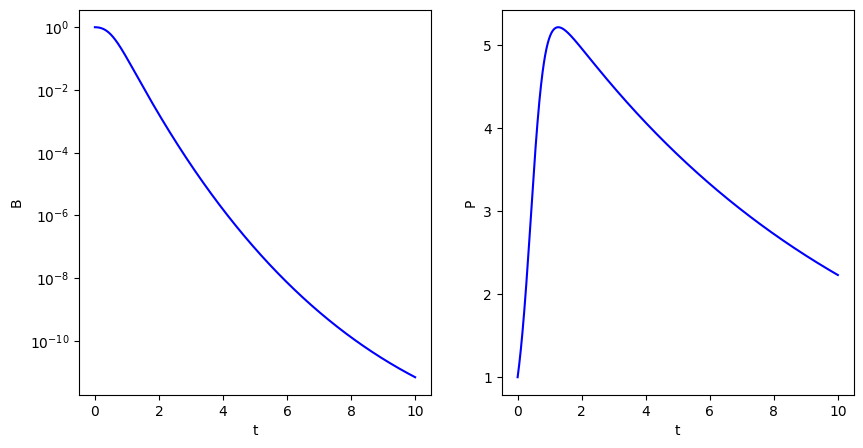

In [63]:
# Determine grid (It assumes one column)
cols = system_dim
rows = 1

# Fig size
width = 5*cols
height = 5*rows

# Generate figure object
fig, ax = plt.subplots(rows, cols, figsize=(width, height))
title = 'Individual dynamics'

# Plot individual dynamics

## Common independent variable
x = solution.t
x_label = indep_variable_symbol
x_variable = 'linear'

## Plot each dependent variable
y_variables_scales = [] ## vector storing preferred scales
for i in range(system_dim):

  ## Grid index
  (row,col) = divmod(i,cols)

  ### Variable
  y = solution.y[i]
  y_label = depend_variables_symbol[i]

  ### Choose scale
  #### If the variable contains a zero, use linear
  if 0 in y:
    y_scale = 'linear'
    print('y contains a zero')

  #### If variable contains positive and negative values, use linear
  elif len(y[y>0])*len(y[y<0])<0:
    y_scale = 'linear'
    print('y contains positive and negative values')

  #### If the values are within two orders of magnitude, use linear
  elif (y.max()/y.min()) <= 100:
    y_scale = 'linear'

  #### Otherwise, use logscale
  else:
    y_scale = 'log'
    print('y contains relatively large max-to-min values')

  print(y_scale)
  ax[col].set_yscale(y_scale)
  y_variables_scales.append(y_scale)

  ### Graph
  ax[col].plot(x, y, 'b-')

  ### Labels
  ax[col].set_xlabel(x_label)
  ax[col].set_ylabel(y_label)

plt.show()

# PerCapFiniT

## Phase diagram

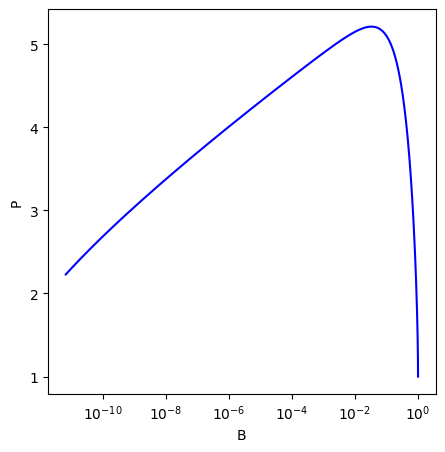

In [13]:
# Plot only if the dimensions of the system are two or larger
if system_dim > 1:
  # Number of phase diagrams (non repeated combination of dependent variables)
  n_phase_diagrams = int(system_dim*(system_dim-1)/2)

  if n_phase_diagrams == 1:
    cols = 1
    rows = 1
  else:
    # Determine grid (rows * cols)
    cols = 3
    rows = ceil(float(n_phase_diagrams)/float(cols))

  # Plot phase diagram dynamics
  ## Figure size
  width = 5*cols
  height = 5*rows

  ## Figure object
  fig, ax = plt.subplots(rows, cols, figsize=(width, height))
  title = 'Phase diagram'

  ## Plot combination of dependent variables
  count = 0 # phase diagram counter
  for i in range(system_dim):
    for j in range(i+1,system_dim):
      ## Grid index
      (col,row) = divmod(count,cols)

      ### Variables
      x = solution.y[i]
      y = solution.y[j]

      x_label = depend_variables_symbol[i]
      y_label = depend_variables_symbol[j]

      ### Set scales
      x_scale = y_variables_scales[i]
      y_scale = y_variables_scales[j]

      if n_phase_diagrams == 1:
        #ax[row,col].set_xscale(x_scale)
        #ax[row,col].set_yscale(y_scale)
        #### Scales
        ax.set_xscale(x_scale)
        ax.set_yscale(y_scale)

        #### Graphs
        ax.plot(x, y, 'b-')

        #### Labels
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

      else:
        #### Scales
        ax[row,col].set_xscale(x_scale)
        ax[row,col].set_yscale(y_scale)

        #### Graphs
        ax[row,col].plot(x, y, 'b-')

        #### Labels
        ax[row,col].set_xlabel(x_label)
        ax[row,col].set_ylabel(y_label)

plt.show()

# Non-abstracted model

In [ ]:
# Model
def lotka_volterra(t, y, r, a, c, m):
  B = y[0]
  P = y[1]

  dBdt = r * B - a * B *P
  dVdt = c * a * B*P  - m*P

  dydt = [dBdt, dVdt]

  return dydt


In [ ]:
# Integrate Lotka-Volterra
# Parameters
r = 1
a = 0.5
c = 0.1
m = 2

# Conditions
B0 = 10
P0 = 10
tobs = 10
tspan = [0, tobs]
max_step = 0.01


# Dynamics
y0 = [B0, P0]
t = np.linspace(0, tobs, 1000)

# Solution
#solution = solve_ivp(lotka_volterra, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
#solution = solve_ivp(lotka_volterra_comp, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
solution = solve_ivp(test_model, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
B = solution.y[0]
P = solution.y[1]

#y = odeint(lotka_volterra, t, y0, args=(r, a, c, m))
#B = y[:, 0]
#P = y[:, 1]

NameError: ignored

In [ ]:
# Plot phase diagram dynamics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(B[:], P[:], 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Bacteria')
plt.ylabel('Phage')
plt.title('Phase diagram')
plt.legend()
plt.show()

In [ ]:
# Integrate pendulum
# Parameters
g = 9.8
l = 1

# Conditions
Theta0 = 10
Omega0 = 1
tobs = 100
tspan = [0, tobs]
max_step = 0.01


# Dynamics
y0 = [Theta0, Omega0]
t = np.linspace(0, tobs, 1000)

# Solution
#solution = solve_ivp(lotka_volterra, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
#solution = solve_ivp(lotka_volterra_comp, tspan, y0, args=(r, a, c, m), dense_output=True,max_step=max_step)
solution = solve_ivp(test_model, tspan, y0, args=(g, l), dense_output=True,max_step=max_step)
Theta = solution.y[0]
Omega = solution.y[1]

#y = odeint(lotka_volterra, t, y0, args=(r, a, c, m))
#B = y[:, 0]
#P = y[:, 1]

In [ ]:
Theta = solution.y[0]
Omega = solution.y[1]

In [ ]:
# Plot phase diagram dynamics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(Theta[:], Omega[:], 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Theta')
plt.ylabel('Omega')
plt.title('Phase diagram')
plt.legend()
plt.show()

In [ ]:
# Model
def lotka_volterra(y, t, r, a, c, m):
  B = y[0]
  P = y[1]

  dBdt = r * B - a * B *P
  dVdt = c * a * B*P  - m*P

  dydt = [dBdt, dVdt]

  return dydt


In [ ]:
# Parameters
r = 1
a = 0.5
c = 0.1
m = 2

In [ ]:
# Conditions
B0 = 10
P0 = 10
tobs = 10

In [ ]:
# Dynamics
y0 = [B0, P0]
t = np.linspace(0, tobs, 1000)

# Solution
y = odeint(lotka_volterra, y0, t, args=(r, a, c, m))

B = y[:, 0]
P = y[:, 1]

In [ ]:
# Plot phase diagram dynamics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(B[:], P[:], 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Bacteria')
plt.ylabel('Phage')
plt.title('Phase diagram')
plt.legend()
plt.show()

In [ ]:
# Plot individual dynamics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(t, B, 'r-', label='Bacteria')
plt.plot(t, P, 'b-', label='Phage')
ax.set_yscale('log')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population dynamics')
plt.legend()
plt.show()

In [ ]:
# Plot impact of indiviual mechanisms

## Mechanisms
growth = r*B
predation = a*B*P
burst = c*a*B*P
death = m*P

## Percapita and time finit
growth_per_B = tobs*growth/B
predation_per_B = tobs*predation/B
burst_per_P = tobs*burst/P
death_per_P = tobs*death/P

## Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(t, growth_per_B, 'r-', label='Growth')
plt.plot(t, predation_per_B, 'b-', label='Predation')
plt.plot(t, burst_per_P, 'g-', label='Burst')
plt.plot(t, death_per_P, 'k-', label='Death')
ax.hlines(1, 0, tobs, linestyles='dashed')
ax.set_yscale('log')
plt.xlabel('Time')
plt.ylabel('Contribution to dynamics')
plt.title('Percapita and finite time contributions')
plt.legend()
plt.show()

In [ ]:
# prompt: Use the simpy package to generate the Lotka-Volterra model used above to display the mathematical equations. No need to solve them.

import simpy

# Define the model
model = simpy.Environment()

# Define the parameters
r = 1
a = 0.5
c = 0.1
m = 2

# Define the states
B = simpy.Container(model, initial_value=10)
P = simpy.Container(model, initial_value=10)

# Define the processes
def growth(env, b, p):
  while True:
    yield env.timeout(1)
    b.level += r * b.level

def predation(env, b, p):
  while True:
    yield env.timeout(1)
    b.level -= a * b.level * p.level

def burst(env, b, p):
  while True:
    yield env.timeout(1)
    p.level += c * a * b.level * p.level

def death(env, p):
  while True:
    yield env.timeout(1)
    p.level -= m * p.level

# Run the simulation
model.run(until=10)

# Print the results
print(B.level)
print(P.level)
